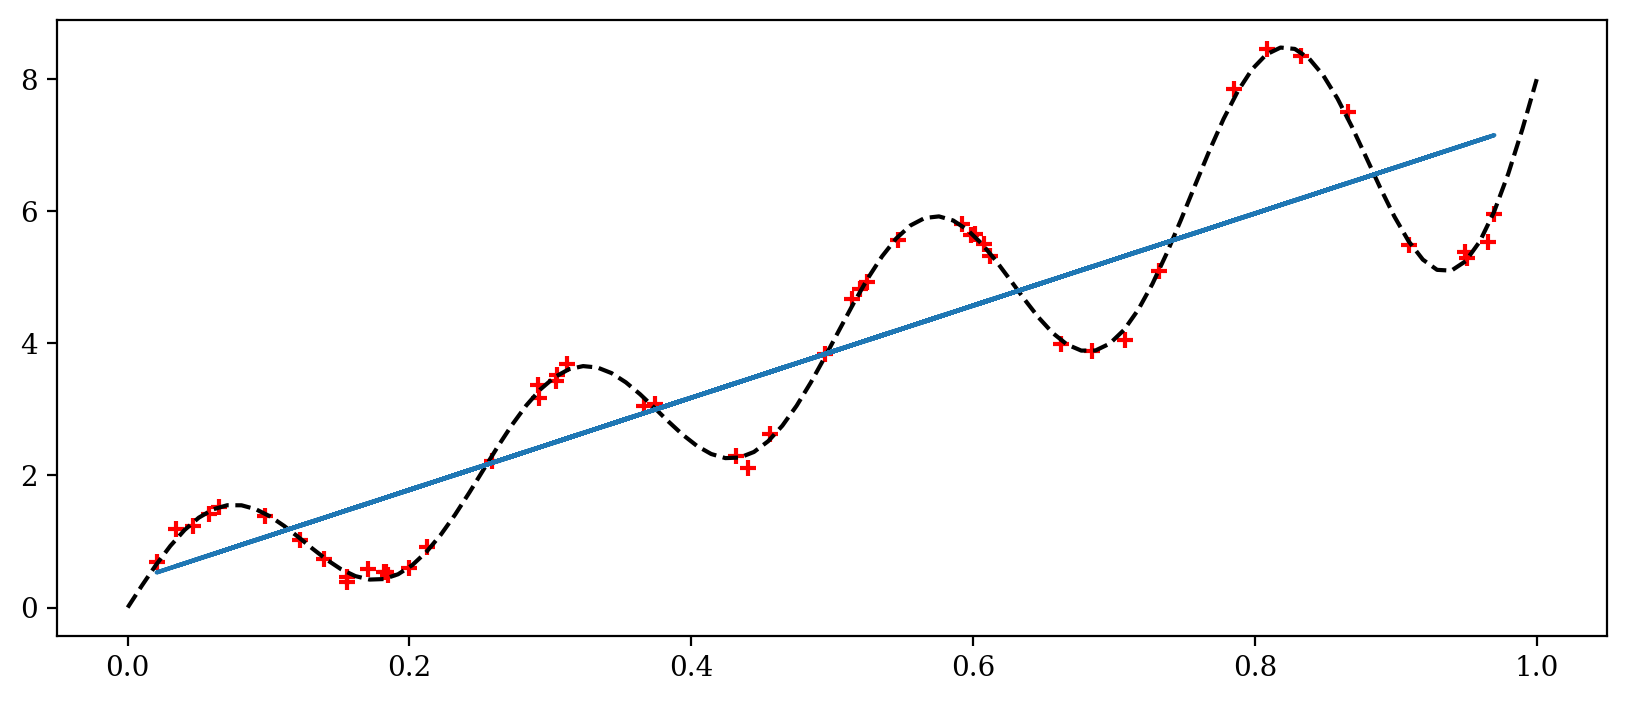

In [7]:
import sys
sys.path.append("..")   # add parent folder (project/) to Python path

from jaxgp.gp import *   # now absolute import works
from apak import *

np.random.seed(42)
N_points = 50
x = uniform(0,1,N_points).reshape(-1,1)
func = lambda x: np.exp(x**2)*np.sin(8*pi*x) + 8*x
y = ( func(x) + randn(x.shape[0], x.shape[1])*1e-1).ravel()
xtest = linspace(0,1,100).reshape(-1,1)
ytest = func(xtest)

figure(figsize=(10,4), dpi=200)
scatter(x,y, marker = '+', color = 'red')
plot(xtest, ytest, linestyle = 'dashed', color = 'black', label = 'target')

Phi = jnp.hstack((jnp.ones((x.shape[0],1)), x))
beta = jla.solve(Phi.T @ Phi + 1e-8 * jnp.eye(Phi.shape[1]), Phi.T @ y)
plot(x, Phi @ beta, label = "Least squares approximation")

In [10]:
model = GP(x, y, RBF, Linear, kernel_params = jnp.ones(2), noise_var = 1e-9, epsilon = 1e-12, max_cond = 1e5, calibrate=True)
p = deepcopy(model.p)
print(neg_mll(model, p))
#optimizer = LBFGS(model, neg_mll, max_iter = 10000, tol = 1e-6, max_stepsize=1e-5, verbose = False)
optimizer = ADAM(model, neg_mll, beta1 = 0.9, beta2 = 0.999)

Calibrated white noise variance: 2.5527e-03
10893.065391839


In [12]:
optimizer.run(1e-2, 10000, ['k_param', 'm_param', 'noise_var'])

100%|██████████| 10000/10000 [00:46<00:00, 217.27it/s, Loss: -2.0416e+00]


{'noise_var': Array(-4.70589951, dtype=float64),
 'k_param': Array([ 3.05572588, -4.30524653], dtype=float64),
 'm_param': Array([-0.12198893,  8.0936536 ], dtype=float64)}

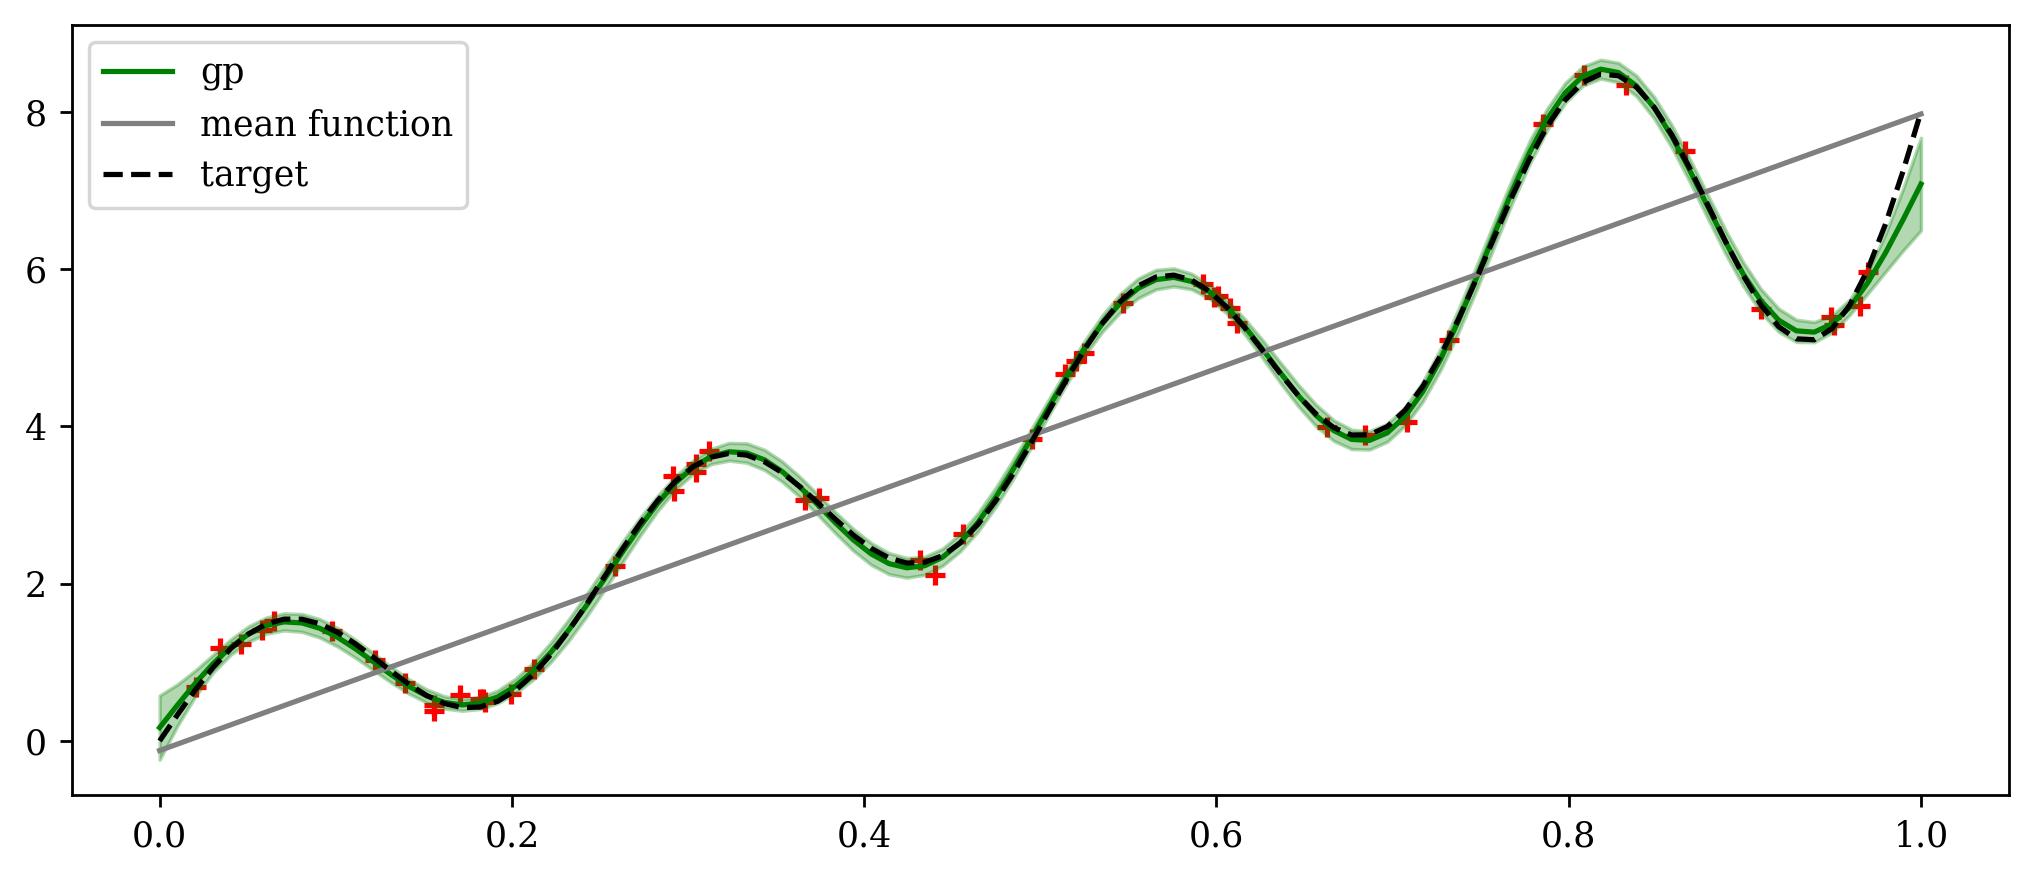

In [14]:
mu, cov = model.predict(xtest, full_cov = False)

figure(figsize=(10,4), dpi = 250)
scatter(x,y, marker = '+', color = 'red')
plot(xtest, mu, color = 'green', label = 'gp')
plot(xtest, model.mean.eval(xtest, model.p['m_param']), color = 'gray', label = 'mean function')
fill_between(xtest.ravel(), mu -2*np.sqrt(cov), mu + 2*np.sqrt(cov), alpha = 0.3, color = 'green')
plot(xtest, ytest, linestyle = 'dashed', color = 'black', label = 'target')
legend()